In [175]:
""" Module for importing PraireView5.0+ generated .csv files."""
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utilities as util
from scipy.optimize import curve_fit
from lxml import etree
from glob import glob
%matplotlib inline

In [176]:
def _get_ephys_vals(element):
    ch_type = element.find('.//PatchclampChannel').text

    if ch_type == '0':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'primary', {'unit': unit, 'divisor': divisor}

    elif ch_type == '1':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'secondary', {'unit': unit, 'divisor': divisor}

In [177]:
def parse_xml(filename):
    tree = etree.parse(filename)
    # find all elements associated with enabled channels
    enabled_ch = tree.xpath('.//Enabled[text()="true"]')

    file_attr = {}
    ch_names = []
    for ch in enabled_ch:
        parent = ch.getparent()
        if parent.find('.//Type').text == 'Physical':
            clamp_device = parent.find('.//PatchclampDevice').text

            if clamp_device is not None:
                name, ephys_vals = _get_ephys_vals(parent)
                file_attr[name] = ephys_vals

            else:
                name = parent.find('.//Name').text

            ch_names.append(name.capitalize())

    file_attr['channels'] = ch_names
    # gets sampling rate
    file_attr['sampling'] = int((tree.find('.//Rate')).text)
    # gets recording time, converts to sec
    file_attr['duration'] = (int((tree.find('.//AcquisitionTime')).text))#/1000

    # finds the voltage recording csv file name
    datafile = (tree.find('.//DataFile')).text
    # finds the linescan profile file name (if doesn't exist, will be None)
    ls_file = (tree.find('.//AssociatedLinescanProfileFile')).text

    # If ls_file is none this could mean that there is no linescan associated
    # with that voltage recording file or that the file passed to parse_vr is
    # actually a LineScan data file and therefore should be passed to ls_file.
    # In that scenario there is no voltage recording file, so vo_file is None
    if ls_file is None:
        if "LineScan" in datafile:
            ls_file = datafile
            vo_file = None
        elif "LineScan" not in datafile:
            vo_file = datafile
    else:
        vo_file = datafile

    file_attr['voltage recording file'] = vo_file
    file_attr['linescan file'] = ls_file

    return file_attr

In [178]:
def import_vr_csv(filename, col_names, primary_div=1, secondary_div=1):
    """
    Reads voltage recording .csv file into a pandas dataframe.
    Will convert Primary and Secondary channels to appropriate values if those
    channels are in the file.
    Returns a dataframe
    """

    df = pd.read_csv(filename, names=col_names, skiprows=1)
    #df.Time /= 1000

    if "Primary" in df.columns:
        df.Primary /= primary_div
    if "Secondary" in df.columns:
        df.Secondary /= secondary_div

    return df



In [179]:
def import_folder(folder):
    """Collapse entire data folder into multidimensional dataframe
    Returns a dictionary with "voltage recording", "linescan" and
    "file attributes" keys associate with 2 dataframes and a dictionary
    (respective).
    """
    vr_xmls = glob(os.path.join(folder, '*_VoltageRecording_*.xml'))

    if any(vr_xmls):
        data_vr = []
        data_ls = []
        sweep_list = []
        file_attr = {}
        output = {}

        for i, file in enumerate(vr_xmls):
            sweep = 'Sweep' + str(i+1).zfill(4)
            sweep_list.append(sweep)
            file_vals = parse_xml(file)

            if file_vals['voltage recording file'] is not None:
                vr_filename = os.path.join(folder,
                                           (file_vals['voltage recording file']
                                            + '.csv'))
                col_names = ['Time'] + file_vals['channels']
                primary_divisor = file_vals['primary']['divisor']
                #secondary_divisor = file_vals['secondary']['divisor']

                df_vr = import_vr_csv(vr_filename, col_names, primary_divisor,1)

                data_vr.append(df_vr)

            if file_vals['linescan file'] is not None:
                ls_filename = os.path.join(folder,
                                           (file_vals['linescan file']))

                df_ls = import_ls_csv(ls_filename)

                data_ls.append(df_ls)

            file_attr['File'+str(i+1)] = file_vals

        if data_vr:
            output["voltage recording"] = pd.concat(data_vr, keys=sweep_list,
                                                    names=['Sweep', 'Index'])
        elif not data_vr:
            output["voltage recording"] = None
        if data_ls:
            output["linescan"] = pd.concat(data_ls, keys=sweep_list,
                                           names=['Sweep', 'Index'])
        elif not data_ls:
            output["linescan"] = None
        output["file attributes"] = file_attr

    else:
        output = {"voltage recording": None, "linescan": None,
                  "file attributes": None}

    return output

In [180]:
vr_folders = glob(os.path.join('/Users/shenyuzhai/Desktop/in_progress/', 'cell1_ctr_40Hz-0**'))
df_vr_list = []
trace_list = []
for i, folder in enumerate(vr_folders):
        col_names = ['Time'] + ['Primary']
        df_vr = import_folder(vr_folders[i])['voltage recording']
        df_vr_list.append(df_vr)
        trace = 'celli-' + str(i+1).zfill(3)
        trace_list.append(trace)
        aligneddata = pd.concat(df_vr_list, keys=trace_list)

temp_vr_all = aligneddata.copy()
vr_avg = temp_vr_all.groupby(level=2).mean()
#vr_avg


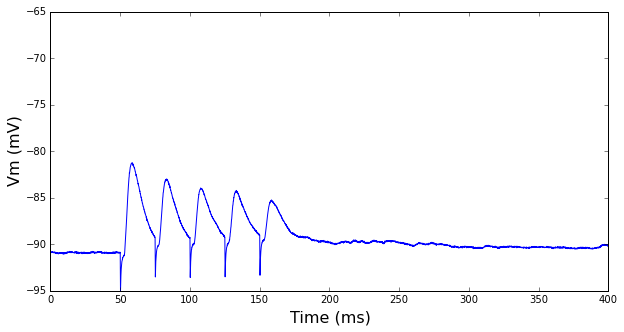

In [181]:
#Plot vr_avg 
plt.figure(figsize=(10,5))
plt.plot(vr_avg.Time, vr_avg.Primary)
plt.ylabel('Vm (mV)', fontsize=16)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylim(-95,-65)
plt.xlim(0,400)
plt.savefig('temporal summation_UL.pdf')

In [182]:
#Plot individual trace to see
#plt.figure(figsize=(10,5))
#plt.plot(df_vr_list[1].Time, df_vr_list[1].Primary)
#plt.ylabel('Vm (mV)', fontsize=16)
#plt.xlabel('Time (ms)', fontsize=16)
#plt.ylim(-95,-75)
#plt.xlim(55,75)

In [183]:
def temporal_summation(df, bsl_start, bsl_end, start_time1, end_time1, start_time2, end_time2, start_time5, end_time5):
    """
    df: data as pandas dataframe
        should contain Time and Primary columns
    bsl_start: designates beginning of the time window for baseline measurement
    bsl_end: designates end of the time window for baseline measurement
    start_time: positive number (time, ms)
        designates beginning of time window for EPSP measurement
    end_time: positive number (time, ms)
        designates end of time window for EPSP measurement
    """
    # have to make copy of df to not modify original df with calculation
    data = df.copy()
    X = data.Time
    bsl_V = data.Primary[(data.Time >= bsl_start) &
                              (data.Time <= bsl_end)].mean()
    EPSP1= (data.Primary[(data.Time>=start_time1) & (data.Time <=end_time1)].max())-bsl_V
    EPSP2= (data.Primary[(data.Time>=start_time2) & (data.Time <=end_time2)].max())-bsl_V
    EPSP5= (data.Primary[(data.Time>=start_time5) & (data.Time <=end_time5)].max())-bsl_V
    EPSP_ratio = EPSP5/EPSP1
    PPR = EPSP2/EPSP1
    result_list = pd.DataFrame(data = [bsl_V, EPSP1, EPSP_ratio, PPR], index = ['Baseline', 'EPSP1', 'EPSP5/EPSP1', 'PPR'], )
    return result_list

In [184]:
#for 20hz trains:
#temporal_summation(vr_avg, 0,50,55,80,105,130,255,280)

#for 40hz trains:
temporal_summation(vr_avg, 0,50,55,70,80,95,155,180)

,0
Baseline,-90.898129
EPSP1,9.675595
EPSP5/EPSP1,0.584450
PPR,0.818641
